In [6]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [21]:
#Abhängigkeiten installieren und einrichten


In [32]:
import os
import time
import uuid
import cv2

In [33]:
IMAGES_PATH = os.path.join('/Users/bergmannjustin/Hand-Recognition/images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
#Bilder mit LabelMe zuschneiden

In [12]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/bergmannjustin/.labelmerc


In [13]:
#TensorFlow und Abhängigkeiten importieren

In [34]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [35]:
#Bild in TensorFlow-Datenpipeline laden

In [45]:
images = tf.data.Dataset.list_files('/Users/bergmannjustin/Hand-Recognition/images/*.jpg')

In [46]:
images.as_numpy_iterator().next()

b'/Users/bergmannjustin/Hand-Recognition/images/24dbc53c-87a4-11ee-8642-3e4ca82df34a.jpg'

In [47]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [48]:
images = images.map(load_image)

In [49]:
images.as_numpy_iterator().next()

array([[[166, 167, 153],
        [167, 168, 154],
        [167, 168, 154],
        ...,
        [173, 178, 174],
        [174, 179, 175],
        [173, 178, 174]],

       [[166, 167, 153],
        [166, 167, 153],
        [163, 164, 150],
        ...,
        [175, 180, 176],
        [176, 181, 177],
        [174, 179, 175]],

       [[162, 163, 149],
        [163, 164, 150],
        [159, 160, 146],
        ...,
        [176, 181, 177],
        [177, 182, 178],
        [174, 179, 175]],

       ...,

       [[ 59,  58,  72],
        [ 62,  61,  75],
        [ 64,  63,  77],
        ...,
        [131, 136, 139],
        [132, 137, 140],
        [129, 134, 137]],

       [[104, 106, 119],
        [106, 108, 121],
        [107, 109, 122],
        ...,
        [130, 135, 138],
        [131, 136, 139],
        [125, 130, 133]],

       [[165, 167, 180],
        [168, 170, 183],
        [169, 171, 184],
        ...,
        [130, 135, 138],
        [132, 137, 140],
        [125, 130, 133]]

In [50]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [51]:
#Rohbilder mit Matplotlib anzeigen

In [52]:
image_generator = images.batch(4).as_numpy_iterator()

In [53]:
plot_images = image_generator.next()

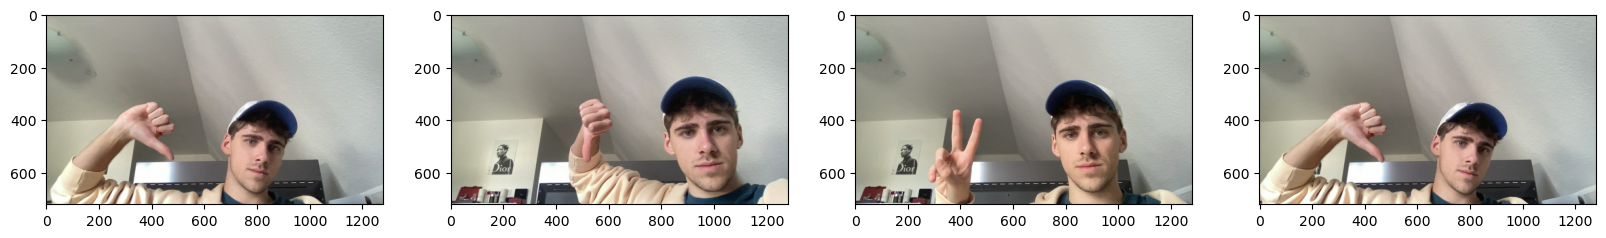

In [55]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [56]:
#Aufteilen von nicht augmentierten Daten

In [57]:
##Manuelles Aufteilen von Daten in Trainings-, Test- und Validierungssets

In [106]:
90*.25 #25 to peace

22.5

In [107]:
90*.25 #25 to yes

22.5

In [108]:
90*.25 #25 to false

22.5

In [109]:
90*.25 #25 to hello

22.5

In [110]:
#Verschieben der übereinstimmenden Labels

In [112]:
source_root = '/Users/bergmannjustin/Hand-Recognition'

for folder in ['false', 'yes', 'peace', 'hello']:
    images_folder = os.path.join(source_root, folder, 'images')
    labels_folder = os.path.join(source_root, folder, 'labels')

    for file in os.listdir(images_folder):
        image_filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join(source_root, 'labels', image_filename)

        if os.path.exists(existing_filepath):
            new_filepath = os.path.join(labels_folder, image_filename)
            os.replace(existing_filepath, new_filepath)
    

In [113]:
#Bildaugmentation auf Bildern und Labels mit Albumentations anwenden

In [114]:
#Albumentations-Transformations-Pipeline einrichten

In [115]:
import albumentations as alb

In [117]:
augmentor = alb.Compose([alb.RandomCrop(width=1280, height=720), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [119]:
#Eine Testgrafik und Annotation mit OpenCV und JSON laden

In [120]:
img = cv2.imread(os.path.join('/Users/bergmannjustin/Hand-Recognition/images/22d4c194-87a4-11ee-8642-3e4ca82df34a.jpg'))


In [122]:
with open(os.path.join('/Users/bergmannjustin/Hand-Recognition/peace/labels/22d4c194-87a4-11ee-8642-3e4ca82df34a.json'), 'r') as f:
    label = json.load(f)

In [123]:
label['shapes'][0]['points']

[[414.4565217391305, 374.6739130434782],
 [719.8913043478261, 695.3260869565217]]

In [124]:
#Extrahieren von Koordinaten und Skalieren, um der Bildauflösung zu entsprechen"

In [125]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [126]:
coords

[414.4565217391305, 374.6739130434782, 719.8913043478261, 695.3260869565217]

In [127]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [128]:
coords

[0.3237941576086957,
 0.5203804347826086,
 0.5624150815217391,
 0.9657306763285024]

In [129]:
#Augmentationen anwenden und Ergebnisse anzeigen

In [134]:
# Annahme: label enthält das gewünschte Label ('face', 'peace', 'hello', 'false', 'yes')
augmented = augmentor(image=img, bboxes=[coords], class_labels=[label])



In [135]:
augmented['bboxes'][0][2:]

(0.6762058423913043, 0.47961956521739135)

In [136]:
augmented['bboxes']

[(0.43758491847826086,
  0.0342693236714976,
  0.6762058423913043,
  0.47961956521739135)]

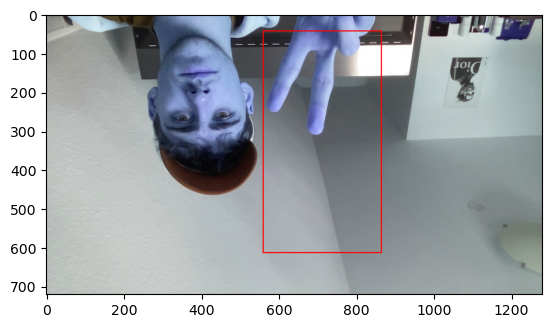

In [137]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [1280,1280]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [1280,1280]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])
